In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.feature import match_template
import matplotlib.patches as patches
from skimage import io as skio
from skimage.segmentation import slic, mark_boundaries


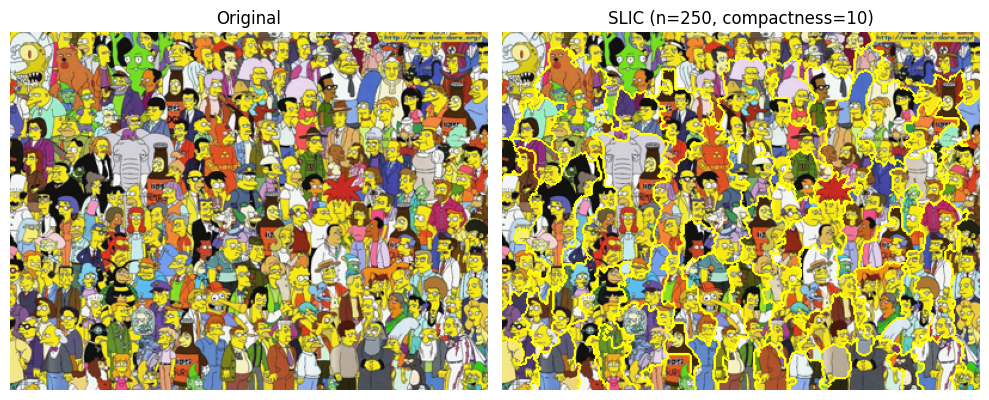

In [30]:
# Q1 — SLIC Superpixels

# Load the search image
IMG_PATH = "search.png"
img = img_as_float(skio.imread(IMG_PATH))

# Run SLIC 
segments_slic = slic(img, n_segments=250, compactness=10)

# Show the superpixel boundaries
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mark_boundaries(img, segments_slic))
plt.title("SLIC (n=250, compactness=10)")
plt.axis("off")

plt.tight_layout()
plt.show()

**Discussion**: SLIC groups nearby pixels with similar colors into superpixels, simplifying the image while keeping important edges. With 250 segments and compactness 10, the regions follow object boundaries well. More segments give finer details, while higher compactness makes regions more evenly shaped

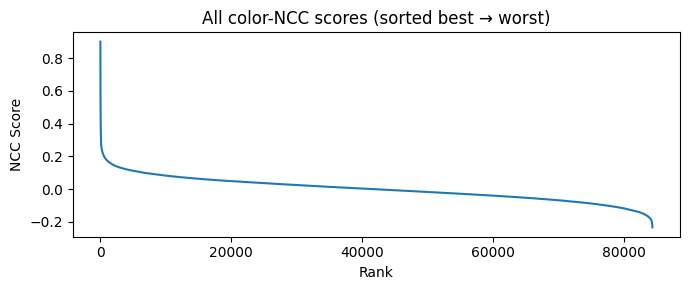

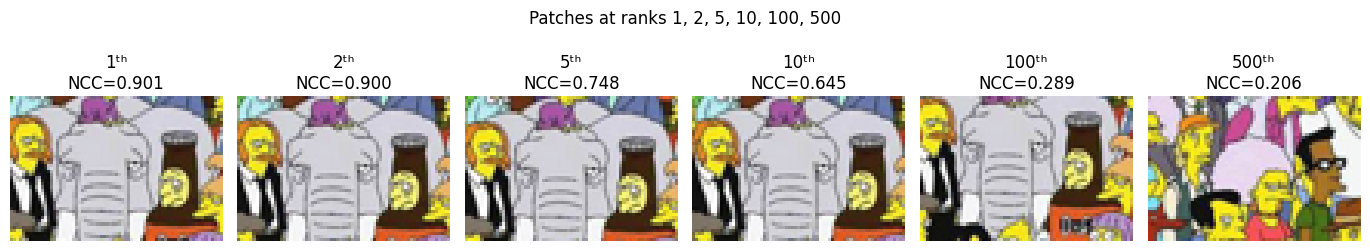

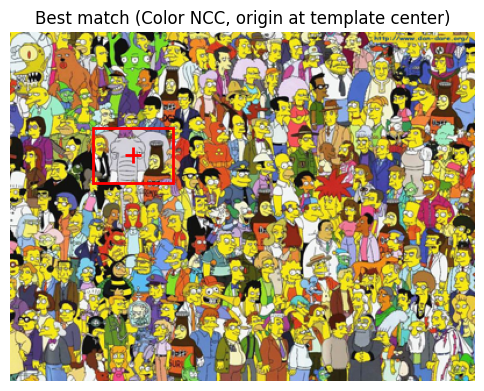

In [31]:
# Q2 — Color-based NCC (unbiased, origin at template center)

# Load images
search_img = img_as_float(io.imread("search.png"))[..., :3]
template = img_as_float(io.imread("template.png"))[..., :3]
h, w, _ = template.shape

# Color-based NCC:
ncc_maps = []
for c in range(3):
    ncc_maps.append(match_template(search_img[..., c], template[..., c], pad_input=False))
ncc = np.mean(ncc_maps, axis=0)  # average NCC over color channels

# Sort scores
flat = ncc.ravel()
order = np.argsort(-flat)  # descending
scores_sorted = flat[order]

# Plot sorted scores
plt.figure(figsize=(7,3))
plt.plot(scores_sorted)
plt.title("All color-NCC scores (sorted best → worst)")
plt.xlabel("Rank")
plt.ylabel("NCC Score")
plt.tight_layout()
plt.show()

# Show 1st, 2nd, 5th, 10th, 100th, and 500th best patches
ranks = [1, 2, 5, 10, 100, 500]
ranks = [r for r in ranks if r <= len(flat)]  # clamp if fewer windows exist

plt.figure(figsize=(2.3*len(ranks), 2.6))
for i, r in enumerate(ranks, 1):
    idx = order[r-1]
    iy, ix = np.unravel_index(idx, ncc.shape)
    patch = search_img[iy:iy+h, ix:ix+w]
    plt.subplot(1, len(ranks), i)
    plt.imshow(patch)
    plt.title(f"{r}ᵗʰ\nNCC={flat[idx]:.3f}")
    plt.axis("off")
plt.suptitle("Patches at ranks 1, 2, 5, 10, 100, 500", y=1.05, fontsize=12)
plt.tight_layout()
plt.show()

# Show best match
best_idx = order[0]
iy, ix = np.unravel_index(best_idx, ncc.shape)
cy, cx = iy + h//2, ix + w//2

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(search_img)
rect = patches.Rectangle((ix, iy), w, h, edgecolor='r', facecolor='none', lw=2)
ax.add_patch(rect)
ax.plot(cx, cy, 'r+', markersize=12, mew=2)
ax.set_title("Best match (Color NCC, origin at template center)")
ax.axis("off")
plt.show()

**Discussion**: Color-based NCC finds the elephant accurately with the highest score. The top matches are close to the correct region, while lower-ranked patches show weaker similarity. The score curve drops quickly, showing only a few strong matches.